In [2]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2022-06-16 13:30:35--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M   165MB/s    in 0.8s    

2022-06-16 13:30:37 (165 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2022-06-16 13:30:37--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===============

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/


Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

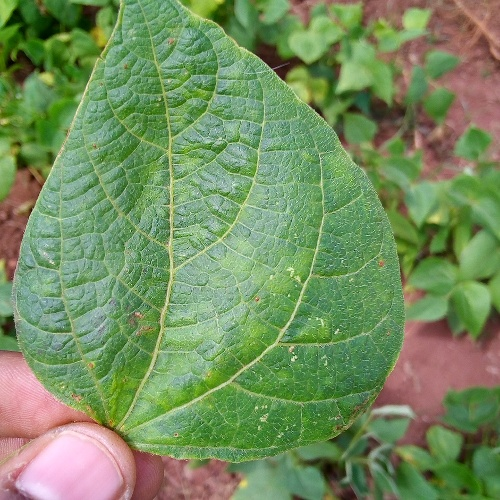

In [6]:
display(Image('beans/train/healthy/healthy_train.45.jpg'))

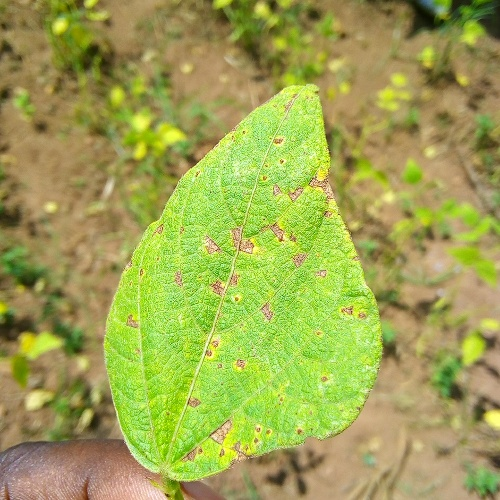

In [7]:
display(Image('beans/validation/angular_leaf_spot/angular_leaf_spot_val.1.jpg'))

In [8]:
batch_size = 128
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [13]:
classes=train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


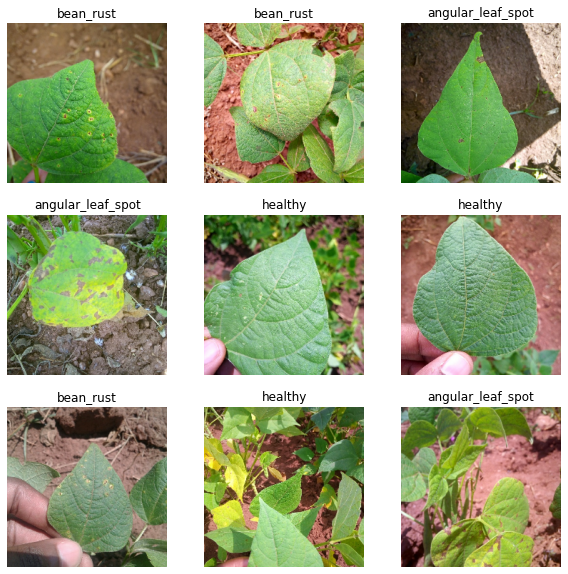

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [17]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [18]:
feature_extractor_layer.trainable = False

In [19]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
tf.random.set_seed(111)

In [21]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 20s 313ms/step - loss: 1.1665 - accuracy: 0.4294 - val_loss: 0.7810 - val_accuracy: 0.6842
Epoch 2/20
9/9 [==============================] - 2s 174ms/step - loss: 0.7853 - accuracy: 0.6441 - val_loss: 0.6034 - val_accuracy: 0.7594
Epoch 3/20
9/9 [==============================] - 1s 147ms/step - loss: 0.6416 - accuracy: 0.7350 - val_loss: 0.5262 - val_accuracy: 0.7594
Epoch 4/20
9/9 [==============================] - 1s 148ms/step - loss: 0.5462 - accuracy: 0.7669 - val_loss: 0.4724 - val_accuracy: 0.7744
Epoch 5/20
9/9 [==============================] - 1s 146ms/step - loss: 0.4918 - accuracy: 0.8037 - val_loss: 0.4385 - val_accuracy: 0.7895
Epoch 6/20
9/9 [==============================] - 1s 147ms/step - loss: 0.4597 - accuracy: 0.8153 - val_loss: 0.4079 - val_accuracy: 0.8045
Epoch 7/20
9/9 [==============================] - 1s 146ms/step - loss: 0.4212 - accuracy: 0.8317 - val_loss: 0.3875 - val_accuracy: 0.8421
Epoch 8/20
9/9 [===

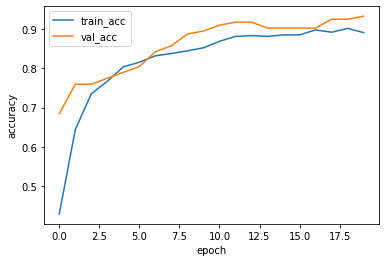

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [26]:
result=model.evaluate(test_ds)

1/1 [==============================] - 0s 478ms/step - loss: 0.2727 - accuracy: 0.8906


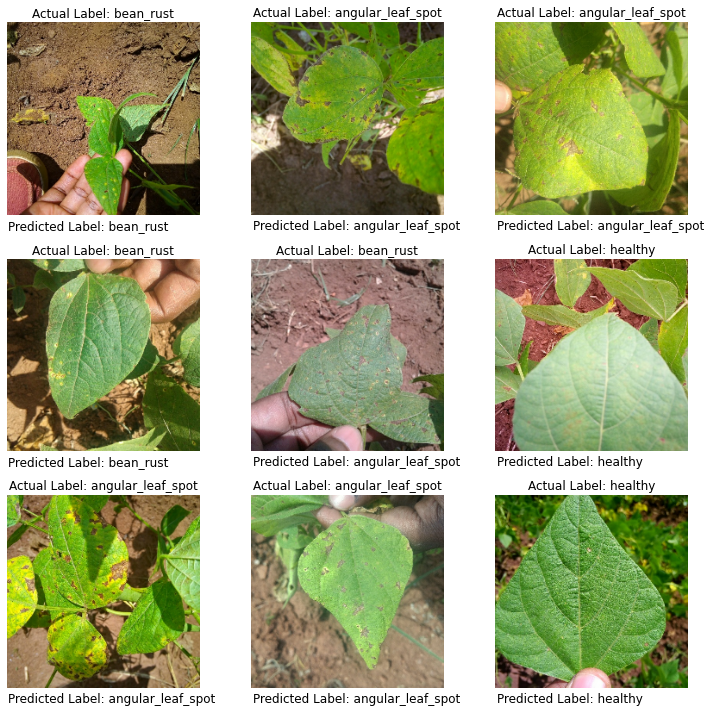

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [28]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [29]:
!ls -alrt models

total 1880
drwxr-xr-x 1 root root    4096 Jun 16 13:35 ..
drwxr-xr-x 2 root root    4096 Jun 16 13:35 variables
drwxr-xr-x 2 root root    4096 Jun 16 13:35 assets
-rw-r--r-- 1 root root 1898534 Jun 16 13:35 saved_model.pb
-rw-r--r-- 1 root root    6922 Jun 16 13:35 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Jun 16 13:35 .


In [30]:
model_loaded = tf.keras.models.load_model('./models/')

In [31]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [32]:
pred_label=model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

healthy


In [33]:
pred_label

array([[0.00100766, 0.04009298, 0.9588994 ]], dtype=float32)

In [34]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/keras_metadata.pb (deflated 82%)
  adding: models/assets/ (stored 0%)
